# Elastic rod impacted by stiff sphere

Two objects take part in this problem:

1. Discretized equations of motion (EoM) of the elastic rod are written as

$$M \ddot{r}_u(t) + K r_u(t) = F(t)$$

The mass matrix and the stiffness matrix are know. The vector of nodal displacement is unknown. 

2. The stiff spherical impactor is modelled as 1 degree of freedom and its EoM is written in form

$$ m_0 r_{u_0} = -F(t)$$

where $F(t)$ denotes the unknown contact force between the elastic rod and the impactor. Quantities attributed to impactor are denoted by subscript $(\bullet)_0$.

The contact force depends on indentation depth

$$F(d)=\frac{4}{3}E^*R^\frac{1}{2}d^\frac{3}{2}$$

where $d$ is the penetration depth, $E^*$ is the effective Young's modulus and $R$ is the radius of the sphere.
 
The indentation depth is difference between the displacement of the impactor $r_{u_0}$ and the displacement of the impacted node at the elastic body $r_{u_c}$

$$d=r_{u_0}-r_{u_c}$$




In [1]:
# 1D rod model loaded impacted by stiff 1DoF impactor.
# The contact force follows Hertz law for friction-less
# Hertzian contact between sphere and plane surfaces.
# 
# Two solution approaches:
#
# Approach #1:
# Numerical integration with respect to time of equations of motion of
# a) the elastic rod: M ddu(t) + K u(t) = F(u_imp - u_c)
# and
# b) the stiff 1DoF impactor: m_imp ddu_imp = - F(u_imp - u_c)
#
# Approach #2:
# "Rozklad do vlastnich tvaru". Perform modal analysis, create modal mass matrix m
# modal stiffness matrix k. Select only few first eigen frequencies.
# Integrate with respect to time the modal version of EoM together with normal version of impactor EoM.

%matplotlib inline
#%matplotlib notebook
import math
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation, rc # Required for plot animation
from IPython.display import HTML     # Required for plot animation

# helpers
def is_diagonal(A):
    """Test if the matirx is diagonal."""
    return np.count_nonzero(A - np.diag(np.diagonal(A))) == 0

In [2]:
# Num nodes
n = 50

# Model parameters
E = 0.1 # Young's modulus
A = 1.0 # Cross section area
rho = 10.0 # Density
l = 0.01 # Element length 

# Wave velocity
c = math.sqrt(E / rho)
print('Wave velocity c = {} m/s'.format(c))

# Nodal coordinates
x = np.array([i*l for i in range(n)])
print('Nodal coordinates')
print(x)

Wave velocity c = 0.1 m/s
Nodal coordinates
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49]


Matrix K
[[ 10. -10.   0.   0.]
 [-10.  20. -10.   0.]
 [  0. -10.  20. -10.]
 [  0.   0. -10.  20.]]
[[ 20. -10.   0.   0.]
 [-10.  20. -10.   0.]
 [  0. -10.  20. -10.]
 [  0.   0. -10.  10.]]


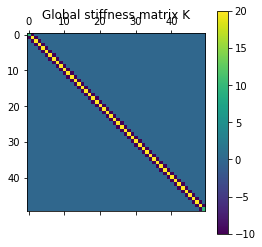

In [3]:
# Stiffness matrix
k = E*A/l
K = scipy.sparse.diags([-k, 2*k, -k], [-1, 0, 1], shape=(n, n)).toarray()
K[0,0] = k
K[n-1, n-1] = k
print('Matrix K')
print(K[:4,:4])
print(K[-4:,-4:])
plt.matshow(K)
plt.title('Global stiffness matrix K')
plt.colorbar()
plt.show()

Matrix M
[[0.05 0.   0.  ]
 [0.   0.1  0.  ]
 [0.   0.   0.1 ]]
[[0.1  0.   0.  ]
 [0.   0.1  0.  ]
 [0.   0.   0.05]]


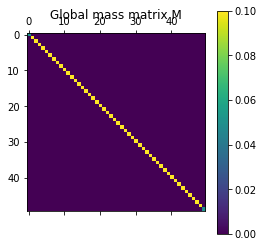

In [4]:
# Mass matrix
m = rho*A*l/2
M = scipy.sparse.diags([2*m], [0], shape=(n, n)).toarray()
M[0, 0] = m
M[n-1, n-1] = m
print('Matrix M')
print(M[:3,:3])
print(M[-3:,-3:])
plt.matshow(M)
plt.title('Global mass matrix M')
plt.colorbar()
plt.show()

In [5]:
print('Total mass')
print(np.trace(M))

Total mass
4.8999999999999995


In [6]:
def F(t):
    """
    Defines time-dependent vector of nodal loading forces.
    """
    res = np.zeros(n)
    if t < 2.0:
        res[0] = 1.0
    return res

Number of time points: 201
Matrix y:
[[ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 8.49045499e-002  7.29362377e-003  2.49512025e-004 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 2.18155499e-001  7.84405167e-002  1.15511627e-002 ...  2.35025884e-127
   1.35549830e-131  1.20747768e-135]
 ...
 [ 6.32832011e+000  6.36131823e+000  6.40606014e+000 ...  3.73966062e-003
   6.59778397e-002  3.40997508e-002]
 [ 6.47327868e+000  6.50416187e+000  6.56008057e+000 ... -2.20598125e-002
   6.97786007e-002 -6.62550090e-002]
 [ 6.67437929e+000  6.67358252e+000  6.72700539e+000 ...  2.64908162e-002
  -9.27818312e-002  3.16848182e-002]]


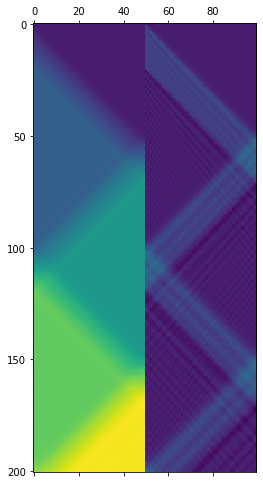

In [7]:
# duration and timestep
T = 20.0
#dt = 0.2
dt = l / c


# scipy.integrate.odeint() used for vector-valued function
# Solves the initial value problem for stiff or non-stiff systems of first order ode-s:
# dy/dt = func(y, t, ...)  [or func(t, y, ...)]

# Here y stores nodal displacements u followed by nodal velocities v.
def f_vec(y, t, K, M, F):
    """Some vector-valued function to be integrated."""
    #K, M = args
    if not is_diagonal(M):
        raise Exception('Mass matrix M is not diagonal.')
    if (len(y) % 2) != 0:
        raise Exception('Odd length of vector y.')
    n = int(len(y)/2)

    M_inv = np.linalg.inv(M)    
    u = y[:n]
    v = y[n:]
    dudt = v
    dvdt = np.matmul(M_inv, F(t) - np.matmul(K, u))
    return np.concatenate([dudt, dvdt])

t = np.arange(0.0, T, dt)
num_time_points = len(t)
print("Number of time points: {}".format(num_time_points))

u0 = np.zeros(n)
#u0 = 0.1 * x**2
v0 = np.zeros(n)
#v0[0] = 0.1
y0=np.concatenate([u0, v0])
y = sp.integrate.odeint(f_vec, y0, t, args=(K, M, F))

print("Matrix y:")
print(y)
plt.matshow(y)
plt.show()

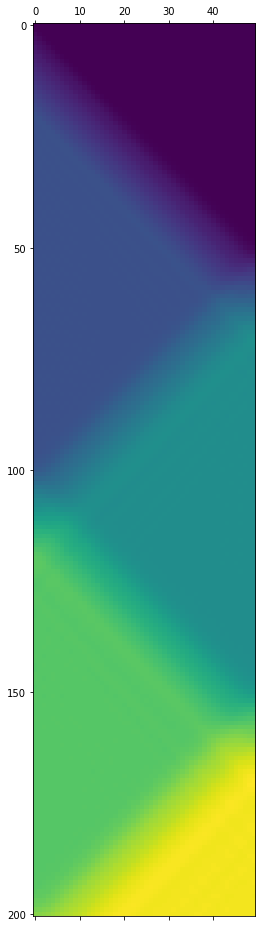

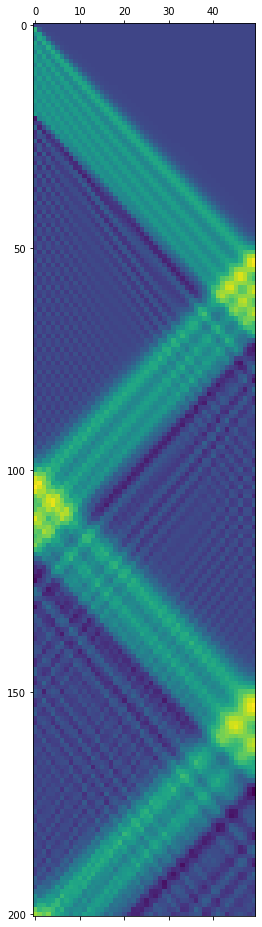

In [8]:
u, v = y[:,:n], y[:,n:]
plt.matshow(u)
plt.show()
plt.matshow(v)
plt.show()

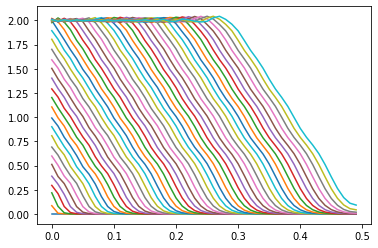

In [9]:
for i in range(n):
    plt.plot(x,u[i])
plt.show()

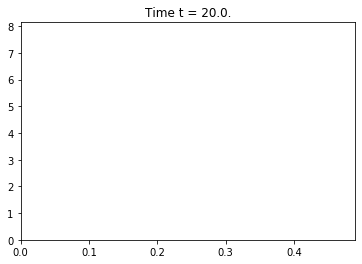

In [10]:
#%matplotlib inline
#%matplotlib notebook
# Simple animated chart
# Based on https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

fig = plt.figure()
ax = plt.axes(xlim=(np.amin(x), np.amax(x)), ylim=(np.amin(u), np.amax(u))) # Ranges of x and y axes
line, = ax.plot([], [], lw=2) # line object with empty data
#ax.set_title('')

def init():
    line.set_data([], [])
    #ax.set_title('')
    return line,

def animate(i):
    line.set_data(x, u[i])
    ax.set_title('Time t = {}.'.format(t[i]))
    return line,

# Setting blit=True makes problems with animated title.
anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=False)
#anim.save('eom_odeint_animation.gif', writer='imagemagick')
anim.save('eom_odeint_animation.mp4')



In [11]:
    #from IPython.display import HTML
    #HTML('<img src="./eom_odeint_animation.gif">')

In [12]:
from IPython.display import Video
Video("eom_odeint_animation.mp4")

First few (6) eigenvalues lam = [-9.19075366e-15+0.j  4.10921450e-01+0.j  1.64199724e+00+0.j
  3.68816860e+00+0.j  6.54102739e+00+0.j  1.01888506e+01+0.j]


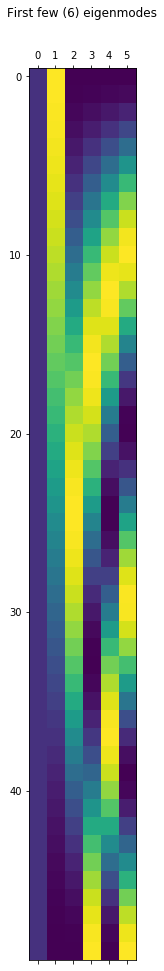

In [13]:
# Solving generalized eigenvalue problem (A - lam * B) * v = 0
# https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix#Generalized_eigenvalue_problem
lam, Q = scipy.linalg.eig(K, M)

# Sorting eigenvalues and eigenvectors
#idx = lam.argsort()[::-1] # Use when sorting from largest to smallest.
idx = lam.argsort() # Use when sorting from smallest to largest.
lam = lam[idx]
Q = Q[:,idx]

# Print first few modes
few = 6
print('First few ({}) eigenvalues lam = {}'.format(few, lam[:6]))
plt.matshow(Q[:,:few])
plt.title('First few ({}) eigenmodes'.format(few))
plt.show()

In [14]:
# Eigenmode decomposition method (Metoda rozkladu do vlastnich tvaru)

# Test whether solution fullfills equation
i = 0
res1 = np.matmul(K - lam[i] * M, Q[:, i])
error1 = np.linalg.norm(res1)
print("First few elements of (K - lam[i] * M) * Q[:, i]. Should be zeros.")
print(res1[:10])
print("Error is: {}".format(error1))


def get_eigen_error(K, M, lam, Q, i):
    """
    Returns norm of vectors of residuals norm((K - lam_i * M) * Q_i).
    """
    residuals = np.matmul(K - lam[i] * M, Q[:, i])
    error = np.linalg.norm(residuals)
    return error

errors = np.array([get_eigen_error(K, M, lam, Q, i) for i in range(len(lam))])

print("Errors are: {}".format(errors))
print("Norm of all errors: {}".format(np.linalg.norm(errors)))


First few elements of (K - lam[i] * M) * Q[:, i]. Should be zeros.
[ 1.33226763e-15+0.j -1.33226763e-15+0.j  1.77635684e-15+0.j
 -1.77635684e-15+0.j -4.88498131e-15+0.j  3.10862447e-15+0.j
  1.77635684e-15+0.j  1.77635684e-15+0.j -5.77315973e-15+0.j
 -4.44089210e-16+0.j]
Error is: 2.0361623449524305e-14
Errors are: [2.03616234e-14 1.78754742e-14 1.98981926e-14 3.26582121e-14
 2.10856991e-14 2.39309122e-14 2.39053224e-14 4.04122706e-14
 2.73334120e-14 1.92585497e-14 2.17826856e-14 1.93326700e-14
 3.36039678e-14 2.66049933e-14 2.53461752e-14 2.85879768e-14
 2.23959979e-14 2.39067977e-14 2.14115749e-14 2.14894990e-14
 2.82036018e-14 4.21611031e-14 3.71247264e-14 3.92879414e-14
 2.94843679e-14 3.49707903e-14 3.38761962e-14 3.41620318e-14
 2.85106916e-14 3.34148601e-14 3.18167838e-14 4.46958422e-14
 3.87069894e-14 4.12430599e-14 2.93442894e-14 3.67064313e-14
 3.60140573e-14 2.30206064e-14 4.05153500e-14 2.84041942e-14
 4.74121332e-14 4.95201805e-14 4.21585175e-14 4.10320471e-14
 4.01325492e

In [15]:
mach_eps = np.finfo(float).eps
print("Machine epsilon: {}".format(mach_eps))

print("Norm of errors is close to zero: {}".format(np.linalg.norm(errors) < math.sqrt(mach_eps)))

Machine epsilon: 2.220446049250313e-16
Norm of errors is close to zero: True


Number of all eigenmodes: 50


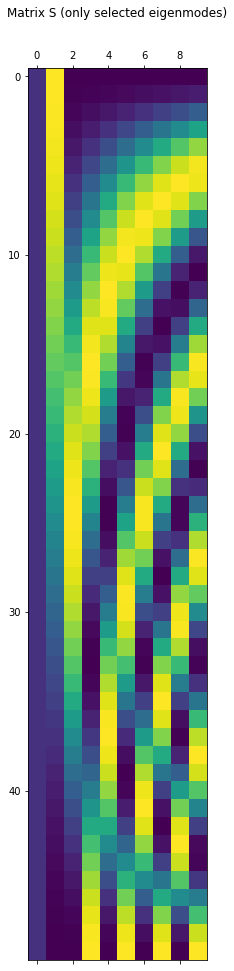

In [16]:
# Now prepare matrix S containing n first eigenmodes
print("Number of all eigenmodes: {}".format(len(lam)))

#num_chosen_eigenmodes = len(lam) # Max size
num_chosen_eigenmodes = 10 # Max size

S = Q[:,:num_chosen_eigenmodes]
plt.matshow(S)
plt.title('Matrix S (only selected eigenmodes)')
plt.show()


In [17]:
def transform_matrix(T, A):
    """
    Returns T^T * A * T
    """
    return np.matmul(np.transpose(T), np.matmul(A, T))

# Compute modal mass matrix and modal stiffness matrix
m_mod = transform_matrix(S, M)
k_mod = transform_matrix(S, K)

# Print it
print("Modal mass matrix m_mod:")
print(np.shape(m_mod))
#print(m_mod)
print("Modal stiffness matrix k_mod:")
print(np.shape(k_mod))
#print(k_mod)



Modal mass matrix m_mod:
(10, 10)
Modal stiffness matrix k_mod:
(10, 10)


In [18]:
# Vector of modal loading f(t)
# Transform vector of nodal loading into vector of "modal" loading.
def f_mod(t):
    return np.matmul(np.transpose(S), F(t))

def f_mod_i(i):
    def inner_function(t):
        return f_mod(t)[i]
    return inner_function
    

In [19]:
# Integrate equation(s) m*ddq(t) + k*q(t) = f(t)

# Here y stores modal displacement u_mod followed by modal velocities v_mod.
def fun_mod(y_mod, t, K_mod, M_mod, F_mod):
    """Some function to be integrated."""
 
    u_mod = y_mod[0]
    v_mod = y_mod[1]
    dudt = v_mod
    dvdt = 1.0 / M_mod * (F_mod(t) - K_mod * u_mod)
    return np.array([dudt, dvdt])


def get_u_mod(i):
    """
    Returns evolution of i-th modal displacement
    """
    # Initial values
    u_mod_0 = 0.0
    v_mod_0 = 0.0
    y_mod_0 = np.array([u_mod_0, v_mod_0])
    # Integrate
    y_mod = sp.integrate.odeint(fun_mod, y_mod_0, t, args=(k_mod[i,i], m_mod[i,i], f_mod_i(i)))
    u_mod = y_mod[:, 0]
    return u_mod


i = 0
print("u_mod[{}], first few".format(i))
print(get_u_mod(i)[:7])


i = 3
print("u_mod[{}], first few".format(i))
print(get_u_mod(i)[:7])


res = np.transpose(np.array([get_u_mod(i) for i in range(num_chosen_eigenmodes)]))
np.shape(res)
np.shape(res[0])

def get_u_nodal(S, q):
    """
    Returns nodal displacement for given modal displacements.
    """
    return np.matmul(S, q)
    
u_nod = np.array([get_u_nodal(S, q) for q in res])
print(np.shape(u_nod))
print(np.shape(u_nod[0]))
print(np.shape(u_nod[0,:]))
print(np.shape(u_nod[:,0]))




u_mod[0], first few
[ 0.         -0.00721538 -0.0288615  -0.06493838 -0.11544601 -0.18038438
 -0.25975351]
u_mod[3], first few
[ 0.         -0.01027398 -0.04071817 -0.09021318 -0.15693914 -0.23844266
 -0.33172697]
(201, 50)
(50,)
(50,)
(201,)


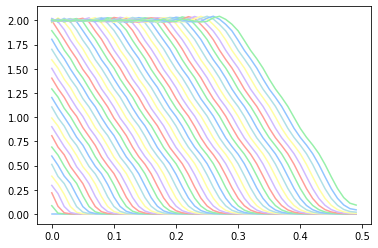

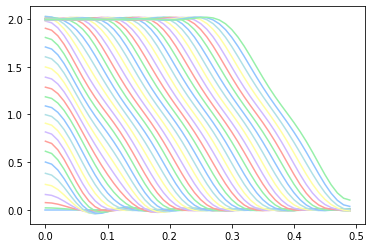

In [20]:
for i in range(n):
    plt.plot(x,u[i])
plt.show()

for i in range(n):
    plt.plot(x,u_nod[i])
plt.show()

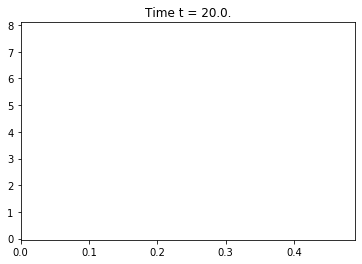

In [21]:
# Animate evolution of nodal displacement computed by modal decomposiion.

#%matplotlib inline
#%matplotlib notebook
# Simple animated chart
# Based on https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

fig = plt.figure()
ax = plt.axes(xlim=(np.amin(x), np.amax(x)), ylim=(np.amin(u_nod), np.amax(u_nod))) # Ranges of x and y axes
line, = ax.plot([], [], lw=2) # line object with empty data
#ax.set_title('')

def init():
    line.set_data([], [])
    #ax.set_title('')
    return line,

def animate(i):
    line.set_data(x, u_nod[i])
    ax.set_title('Time t = {}.'.format(t[i]))
    return line,

# Setting blit=True makes problems with animated title.
anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=False)
#anim.save('eom_odeint_animation.gif', writer='imagemagick')
anim.save('eom_odeint_animation_nod.mp4')



In [22]:
from IPython.display import Video
Video("eom_odeint_animation.mp4")

In [23]:
Video("eom_odeint_animation_nod.mp4")